In [1]:
import sys
from pathlib import Path
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.util as ut
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit
import nitools as nt
import pandas as pd
import seaborn as sb
import numpy as np
from PcmPy import matrix


base_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

In [128]:
D = pd.read_csv(base_dir + 'Profiles/' +
                'NettekovenSym32_profile_individ.tsv', delimiter='\t')
Data = D[D.dataset == 'MDTB']

In [132]:
regions_specific = ['A1L', 'A1R', 'A2L', 'A2R', 'A3L', 'A3R', 'A4L', 'A4R']
# reg_colors = [[0.681,0.2444,0.2878],[1.0,0.4204,0.7005],[0.9399,0.3261,1.0],[0.8166,0.1178,0.5079]]

lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, regions_all = nt.read_lut(lut_dir +
                              'NettekovenSym32.lut')
regions_all=regions_all[1:]

regions = regions_all


In [133]:

Data = Data[['condition'] + regions]



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_24725/3377680342.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  T = T.melt(id_vars='condition', var_name='region', value_name='value')


,condition,region,value,side,reg,task
0,NoGo,region,region,n,re,NoGo
1,Go,region,region,n,re,Go
2,ToM,region,region,n,re,ToM
3,VideoAct,region,region,n,re,VideoAct
4,VideoKnots,region,region,n,re,VideoKnots


<Figure size 1500x600 with 0 Axes>

# Task descriptions over and above motor responses

In [135]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags_final.tsv', sep="\t"
)
# Reduce tags to only MDTB Tasks
tags = tags[tags.dataset == 'MDTB']
# Make condition into index
tags = tags.set_index('condition')

# Drop everything other than mdtb let hand, right hand and saccade features
tags_first_tag_column = tags.columns.tolist().index('left_hand_response_execution')
last_mdtb_tag = tags.columns.tolist().index('saccadic_eye_movement')
tags = tags.iloc[:, tags_first_tag_column:last_mdtb_tag+1]


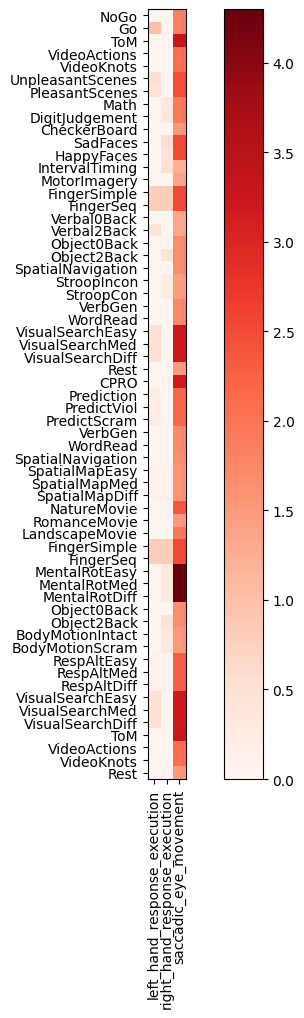

In [136]:
cmap_matrix = plt.get_cmap('Reds')

plt.figure(figsize=(10, 10))
plt.imshow(tags, cmap=cmap_matrix)
plt.yticks(range(tags.shape[0]), tags.index.tolist())
plt.xticks(range(tags.shape[1]), tags.columns.tolist(), rotation=90)
plt.colorbar()


In [137]:
# Repeat the tags for each participant
# Loop through the entries of profile.condition and repeat the tags.condition row
mdtb_new = [
    "VideoAct",
    "VisualSearchSmall",
    "VisualSearchLarge",
    "SpatialMedDiff",
    "rest",
]
mdtb_old = [
    "VideoActions",
    "VisualSearchEasy",
    "VisualSearchMed",
    "SpatialMapDiff",
    "Rest",
]
mdtb_new2old = dict(zip(mdtb_new, mdtb_old))


for i, cond in enumerate(Data.condition):
    try:
        row = tags.iloc[tags.index.tolist().index(cond)]
    except:
        row = tags.iloc[tags.index.tolist().index(mdtb_new2old[cond])]
    if i == 0:
        tags_individ = row
    else:
        tags_individ = pd.concat([tags_individ, row], axis=1)

# Subtract mean from each column and divide by standard deviation of each column
# tags_mat = tags_individ.Data.to_numpy()
# tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)


In [138]:
# Get index of tasks where each task is a number
task_codes = {}
task_indices = []
for task in Data.condition:
    if task not in task_codes:
        task_codes[task] = len(task_codes)+1
    task_indices.append(task_codes[task])

task_matrix = matrix.indicator(task_indices)


In [152]:
Data

,condition,M1L,M2L,M3L,M4L,A1L,A2L,A3L,A4L,D1L,...,A3R,A4R,D1R,D2R,D3R,D4R,S1R,S2R,S3R,S4R
0,NoGo,-1.156838,-1.902668,-1.362296,-1.384418,-2.000948,-1.807591,-1.718664,-2.242846,-1.193170,...,-2.554262,-1.964828,-0.515994,-1.072324,-1.743186,-1.404316,-0.616927,-0.422669,-0.434695,-0.770578
1,Go,-0.565507,-0.981758,1.257374,-0.323802,0.980707,0.419158,-0.010392,-1.046338,-0.433051,...,-0.871022,-1.367517,0.423954,-1.084873,-0.013300,0.173276,0.574417,-0.180363,-0.693865,-0.814318
2,ToM,0.888639,-1.079354,-0.251635,0.010209,-1.078263,-1.145833,-1.252602,-0.294439,-0.143623,...,-1.055745,0.796445,1.171427,1.023364,1.311621,0.645589,2.820274,3.156296,0.737398,0.533528
3,VideoAct,0.703990,2.226665,0.005524,0.879262,-0.067168,0.976709,2.658703,2.183088,0.402453,...,2.606755,2.347622,0.553484,0.294638,0.715387,0.770400,1.219072,0.790458,0.246037,0.433822
4,VideoKnots,1.873162,2.637699,-0.277757,0.597589,0.394914,0.737757,0.857921,2.852013,2.324016,...,0.468085,2.831195,1.642822,1.269825,1.490304,1.298783,2.595356,1.880034,0.735518,0.248879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,VisualSearchLarge,0.975750,-0.403488,0.797712,0.310651,0.096816,0.668195,0.395891,0.134658,-0.110574,...,-0.304435,0.192253,-0.151651,0.000421,-0.587078,-0.561554,-0.437366,0.029810,0.562392,-0.077680
1460,ToM,0.040880,-1.317968,-0.134001,0.182008,-0.523360,-0.532822,-0.732835,-0.447204,-0.161467,...,-0.918676,-0.613488,0.822354,-0.403071,0.923491,0.483853,2.157155,2.283975,0.436690,0.382530
1461,VideoAct,-0.527311,1.623410,-0.266102,-0.493189,-1.127697,0.189918,1.995447,1.019978,-0.941478,...,1.586104,0.916213,-1.244438,-0.657298,-0.340278,-1.048643,-0.684368,-0.113959,-0.099623,-0.344815
1462,VideoKnots,0.249725,0.773994,-0.170816,0.492454,-0.731866,-0.203991,0.570537,0.943640,-0.424635,...,0.202625,0.789094,-0.869293,-0.095320,-0.488916,-0.751178,-0.275045,0.446103,0.577259,0.421452


1364                  ToM
1365             VideoAct
1366           VideoKnots
1367                 rest
1368                 CPRO
              ...        
1459    VisualSearchLarge
1460                  ToM
1461             VideoAct
1462           VideoKnots
1463                 rest
Name: condition, Length: 100, dtype: object


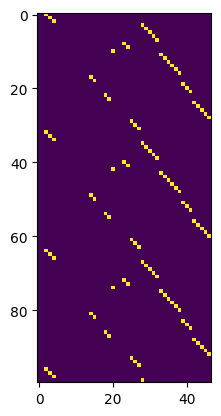

In [151]:
plt.imshow(task_matrix[-100:, -100:])
print(Data.condition[-100:])

# plt.imshow(task_matrix[:100, :100])
# print(Data.condition[:100])


In [153]:
# Concatenate tags_individ and task_matrix
tags_task = np.concatenate((tags_individ.T.to_numpy(), task_matrix), axis=1)


In [155]:
np.sum(tags_task, axis=0)


array([ 241.60000003,  216.79999999, 3230.40000002,   24.        ,
         24.        ,   48.        ,   48.        ,   48.        ,
         24.        ,   24.        ,   24.        ,   24.        ,
         24.        ,   24.        ,   24.        ,   24.        ,
         24.        ,   48.        ,   48.        ,   24.        ,
         24.        ,   48.        ,   48.        ,   48.        ,
         24.        ,   24.        ,   48.        ,   48.        ,
         48.        ,   48.        ,   48.        ,   48.        ,
         24.        ,   24.        ,   24.        ,   24.        ,
         24.        ,   24.        ,   24.        ,   24.        ,
         24.        ,   24.        ,   24.        ,   24.        ,
         24.        ,   24.        ,   24.        ,   24.        ,
         24.        ,   24.        ])

In [154]:
np.mean(tags_task, axis=0)


array([0.16502732, 0.14808743, 2.20655738, 0.01639344, 0.01639344,
       0.03278689, 0.03278689, 0.03278689, 0.01639344, 0.01639344,
       0.01639344, 0.01639344, 0.01639344, 0.01639344, 0.01639344,
       0.01639344, 0.01639344, 0.03278689, 0.03278689, 0.01639344,
       0.01639344, 0.03278689, 0.03278689, 0.03278689, 0.01639344,
       0.01639344, 0.03278689, 0.03278689, 0.03278689, 0.03278689,
       0.03278689, 0.03278689, 0.01639344, 0.01639344, 0.01639344,
       0.01639344, 0.01639344, 0.01639344, 0.01639344, 0.01639344,
       0.01639344, 0.01639344, 0.01639344, 0.01639344, 0.01639344,
       0.01639344, 0.01639344, 0.01639344, 0.01639344, 0.01639344])

In [141]:
tags_task = (tags_task - np.mean(tags_task, axis=0)) / np.std(tags_task, axis=0)


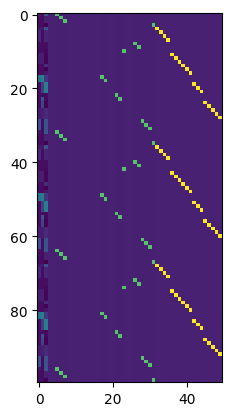

In [142]:
plt.imshow(tags_task[-100:, -100:])

In [143]:
# Zstandardize the data
Data[regions] = (Data[regions] - np.mean(Data[regions], axis=0)) / np.std(Data[regions], axis=0)

In [144]:

Data[regions]

,M1L,M2L,M3L,M4L,A1L,A2L,A3L,A4L,D1L,D2L,...,A3R,A4R,D1R,D2R,D3R,D4R,S1R,S2R,S3R,S4R
0,-1.156838,-1.902668,-1.362296,-1.384418,-2.000948,-1.807591,-1.718664,-2.242846,-1.193170,-1.618944,...,-2.554262,-1.964828,-0.515994,-1.072324,-1.743186,-1.404316,-0.616927,-0.422669,-0.434695,-0.770578
1,-0.565507,-0.981758,1.257374,-0.323802,0.980707,0.419158,-0.010392,-1.046338,-0.433051,-1.017253,...,-0.871022,-1.367517,0.423954,-1.084873,-0.013300,0.173276,0.574417,-0.180363,-0.693865,-0.814318
2,0.888639,-1.079354,-0.251635,0.010209,-1.078263,-1.145833,-1.252602,-0.294439,-0.143623,-1.642732,...,-1.055745,0.796445,1.171427,1.023364,1.311621,0.645589,2.820274,3.156296,0.737398,0.533528
3,0.703990,2.226665,0.005524,0.879262,-0.067168,0.976709,2.658703,2.183088,0.402453,0.700645,...,2.606755,2.347622,0.553484,0.294638,0.715387,0.770400,1.219072,0.790458,0.246037,0.433822
4,1.873162,2.637699,-0.277757,0.597589,0.394914,0.737757,0.857921,2.852013,2.324016,1.385974,...,0.468085,2.831195,1.642822,1.269825,1.490304,1.298783,2.595356,1.880034,0.735518,0.248879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,0.975750,-0.403488,0.797712,0.310651,0.096816,0.668195,0.395891,0.134658,-0.110574,0.135469,...,-0.304435,0.192253,-0.151651,0.000421,-0.587078,-0.561554,-0.437366,0.029810,0.562392,-0.077680
1460,0.040880,-1.317968,-0.134001,0.182008,-0.523360,-0.532822,-0.732835,-0.447204,-0.161467,-1.099858,...,-0.918676,-0.613488,0.822354,-0.403071,0.923491,0.483853,2.157155,2.283975,0.436690,0.382530
1461,-0.527311,1.623410,-0.266102,-0.493189,-1.127697,0.189918,1.995447,1.019978,-0.941478,-1.255483,...,1.586104,0.916213,-1.244438,-0.657298,-0.340278,-1.048643,-0.684368,-0.113959,-0.099623,-0.344815
1462,0.249725,0.773994,-0.170816,0.492454,-0.731866,-0.203991,0.570537,0.943640,-0.424635,-0.504008,...,0.202625,0.789094,-0.869293,-0.095320,-0.488916,-0.751178,-0.275045,0.446103,0.577259,0.421452


In [145]:
Data[regions].to_numpy()


array([[-1.1568382 , -1.90266796, -1.36229576, ..., -0.42266893,
        -0.43469511, -0.77057836],
       [-0.56550674, -0.98175809,  1.25737426, ..., -0.18036316,
        -0.69386531, -0.81431798],
       [ 0.88863905, -1.07935425, -0.25163451, ...,  3.15629616,
         0.73739795,  0.53352809],
       ...,
       [-0.52731118,  1.62340955, -0.26610231, ..., -0.11395947,
        -0.099623  , -0.34481458],
       [ 0.24972495,  0.77399377, -0.17081599, ...,  0.44610254,
         0.57725927,  0.42145197],
       [-0.41267368, -0.55144143, -0.29927022, ...,  1.42762197,
         0.75593921,  1.80589184]])

In [146]:
Data.to_numpy()
tags_task.shape


(1464, 50)

In [147]:
R2, features = ridgeFit(Data[regions].to_numpy(), tags_task,
                        fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[tags_first_tag_column:]
Features = pd.DataFrame(features.T, columns=[
                        'left_hand', 'right_hand', 'saccades'] + list(task_codes.keys()))


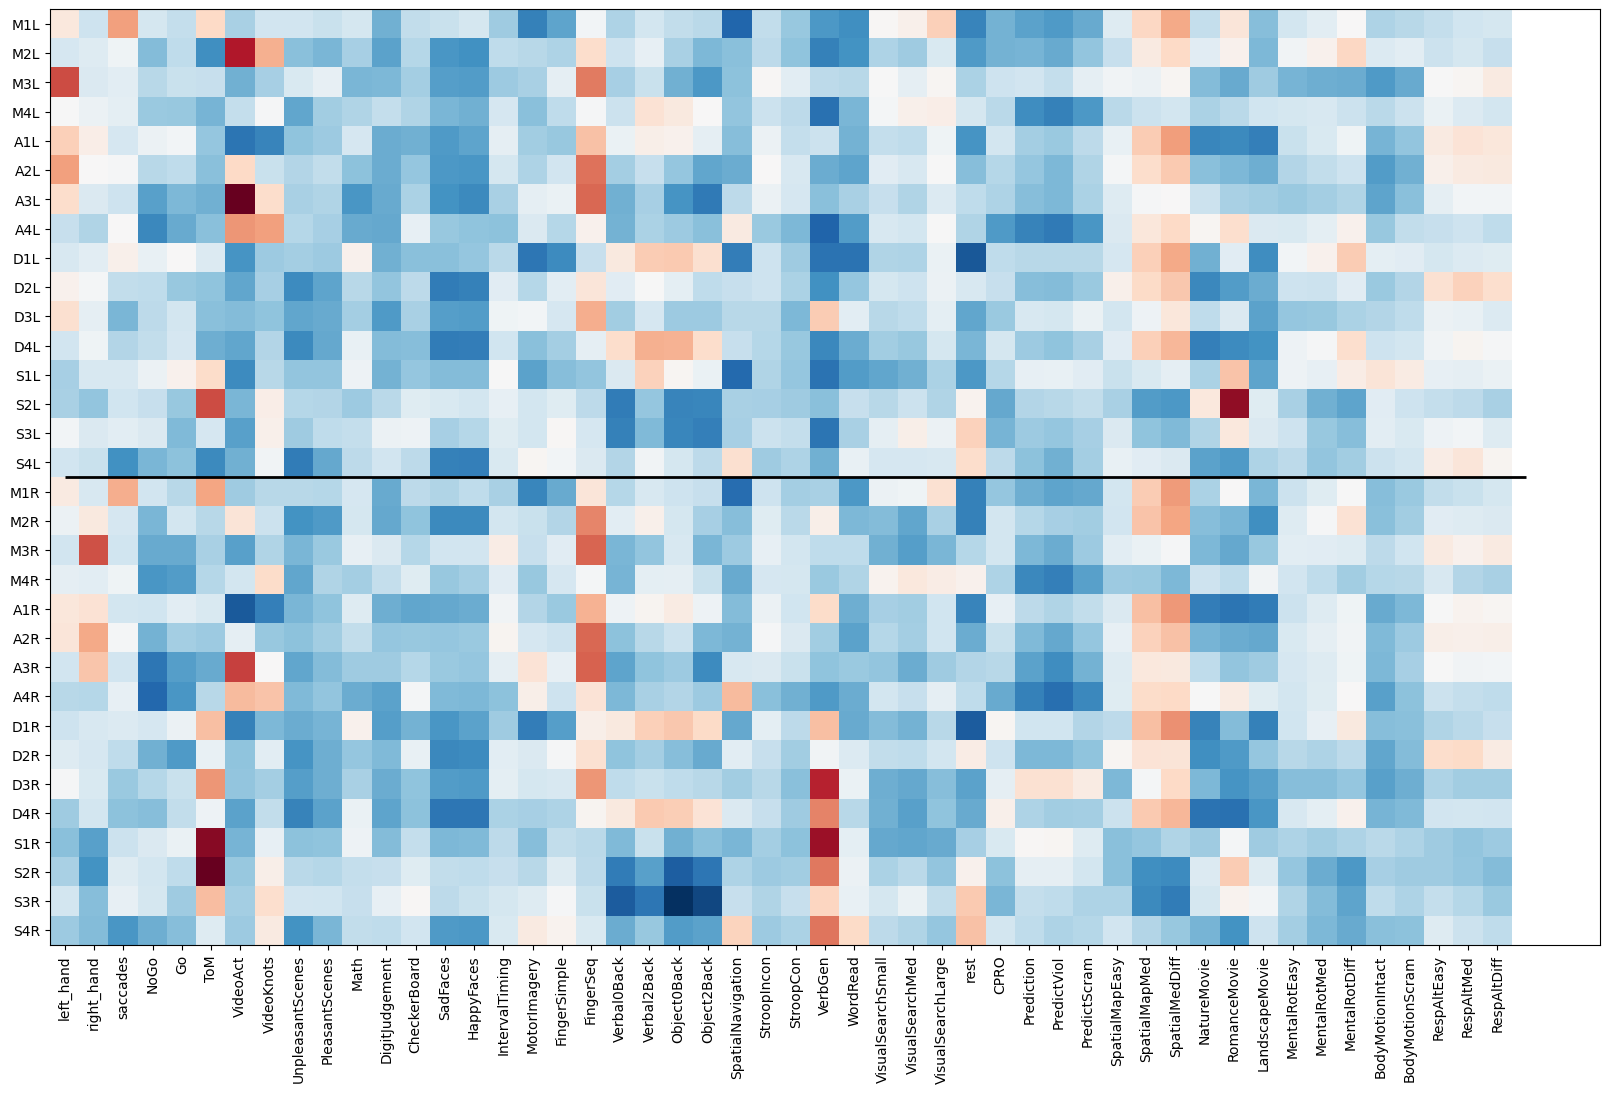

In [161]:
cmap = plt.get_cmap('RdBu_r')

plt.figure(figsize=(20, 20))
plt.imshow(Features, cmap=cmap)
plt.yticks(np.arange(len(regions)), regions)
plt.xticks(np.arange(len(Features.columns.tolist())), Features.columns.tolist(), rotation = 90)

# Plot a horizontal line in the middle
plt.hlines(len(regions)/2-0.5, 0, len(Features.columns.tolist()), color='black', linewidth=2)